In [13]:
import numpy as np
import pickle
from questions.models import Solution, Cluster
from questions.sampling import get_next_sample
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Image

In [6]:
all_clusters = Cluster.objects.all()
print(all_clusters)

<QuerySet [<Cluster: 0 - Math/String>, <Cluster: 1 - Conditional>, <Cluster: 2 - Loop>]>


In [7]:
all_solutions = Solution.objects.filter(ignore=False)
clusters = all_solutions.values('cluster').annotate(count=Count('cluster'))
clusters

<QuerySet [{'cluster': 1, 'count': 10}, {'cluster': 2, 'count': 31}, {'cluster': 0, 'count': 13}]>

### Calculate next problems

Initial conditions

In [8]:
def clear_belief_state():
    # Create X as an empty belief state (X is the machine's model of the student's distribution)
    X = np.zeros(settings.DOC_TOPIC_SHAPE)

    # Get Solution ids in a list, to serve as an index reference to X
    all_solutions = Solution.objects.filter(ignore=False)
    all_solutions_idx = list(all_solutions.values_list('id', flat=True).order_by('id'))

    # Create Y as a document_topic matrix. For the first version, each document belongs to one topic
    Y = np.zeros(settings.DOC_TOPIC_SHAPE)
    clusters = all_solutions.values_list('cluster', flat=True).order_by('id')
    for idx, cluster_value in enumerate(clusters):
        Y[idx, cluster_value] = 1

    # Unpickle similarity matrix (W)
    with open('similarity.pkl', 'rb') as pklfile:
        W = pickle.load(pklfile)

    # Set L as an unlabelled set
    L = []
    
    return X, Y, W, L, all_solutions_idx

In [9]:
def update_belief_state(X, Y, W, L, all_solutions_idx, success_rate, clusters):
    # Get next sample
    solution_idx = get_next_sample(X, Y, W, L)
    solution_cluster = Solution.objects.get(pk=all_solutions_idx[solution_idx]).cluster.pk

    # Draw if user gets it correctly or not
    success = np.random.binomial(1, success_rate)
    print(solution_cluster)
#     print(success)

    if solution_cluster in clusters and success:
        # Got it correcly
        X[solution_idx, solution_cluster] = 1

    # Add it as labeled sample
    L.append(solution_idx)
    return X, Y, L, solution_cluster

In [22]:
# Student A: gets only conditional questions (1) with X% of correctness
success_rate = 1
correct_clusters = [2]
X, Y, W, L, all_solutions_idx = clear_belief_state()
states_transition = []

for i in range(30):
    X, Y, L, solution_cluster = update_belief_state(X, Y, W, L, all_solutions_idx, success_rate, correct_clusters)
    states_transition.append(solution_cluster)

2
2
2
2
2
2
0
2
0
2
0
2
1
1
2
0
0
2
1
0
1
2
0
1
0
2
0
1
0
1


In [23]:
states = list(all_clusters.values_list('pk', flat=True))

# Create transition matrix
Q = np.zeros((len(states), len(states)))
i = 0
while i < len(states_transition)-1:
    Q[states_transition[i], states_transition[i+1]] +=1
    i+=1
    
G = nx.MultiDiGraph()
labels={}
edge_labels={}

for i, origin_state in enumerate(states):
    for j, destination_state in enumerate(states):
        rate = Q[i][j]
        if rate > 0:
            G.add_edge(origin_state,
                       destination_state,
                       weight=rate,
                       label="%d" % rate)
            edge_labels[(origin_state, destination_state)] = label="%d" %rate
            
plt.figure(figsize=(14,7))
node_size = 20
# pos = {state:list(state) for state in states}
pos = nx.circular_layout(G)
# nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G, pos, font_weight=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels)
# nx.draw(G, pos=pos, with_labels=True)
plt.axis('off');

nx.nx_pydot.write_dot(G, 'mc.dot')

In [24]:
!neato -Tps -Kcirco -Goverlap=scale mc.dot -o mc.ps; convert mc.ps mc.png

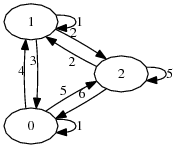

In [25]:
Image("mc.png", width="50%")